In [4]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
from zipfile import ZipFile
from sklearn.preprocessing import MinMaxScaler
from itertools import chain
import datetime
import math

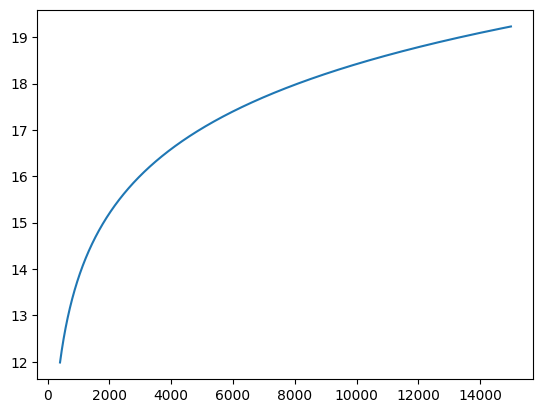

In [5]:
# function for smoothing out the bins when we're calculating a dynamic bin size for our chart
# conceptually, we needed something that grows slower as the value keeps increasing
def f(x):
    return np.log(x)
x = np.linspace(400, 15000, 100000)
y = f(x)
# Plot the Data
plt.plot(x, y)
plt.show()

In [3]:

def create_volume_profile_ticks_standard(data, num_bins = 0, bin_size = 0, minmax_scaler = MinMaxScaler(feature_range = (0,500))):
    # Calculate the price range for binning
    min_price = data['price'].min()
    max_price = data['price'].max()
    price_range = max_price - min_price
    
    #calculate bin size if not provided
    if num_bins != 0:
        bin_size= int(price_range/num_bins)
    
    # Calculate the number of bins
    if bin_size != 0:
        num_bins = int(price_range/bin_size)
    
    # calculate the bin size and number of bins dinamically if not provided
    if num_bins == 0 and bin_size == 0:
        #use two times the natural log of the price range to calculate the bin size
        bin_size = 2*round(math.log(price_range),0)
        num_bins = int(price_range/bin_size)

    # Create the bins
    bins = [min_price + i * bin_size for i in range(num_bins + 1)]

    # Bin the data and calculate total volume for each bin
    volume_profile = []
    for i in range(num_bins):
        bin_data = data[(data['price'] >= bins[i]) & (data['price'] < bins[i+1])]
        total_volume = bin_data['quantity'].sum()      
        volume_profile.append(total_volume)
        
    volume_profile = data = np.array(volume_profile).reshape(-1, 1) 
    
    volume_profile = minmax_scaler.fit_transform(volume_profile)
    
    flattened_list = list(chain.from_iterable(volume_profile.reshape(-1, 1)))
    
    return bins[:-1], flattened_list

def calculate_point_of_control(bins, volume_profile):
    poc_index = np.argmax(volume_profile)
    point_of_control = bins[poc_index]
    
    return point_of_control

def calculate_value_area_with_highest_dual_bins(bins, volume_profile, percentage):
    
    # Find the index of the bin with the greatest volume
    highest_volume_index = volume_profile.index(max(volume_profile))

    # Initialize variables to track the value area
    value_area_low = min(bins)
    value_area_high = max(bins)
    value_area_volume = volume_profile[highest_volume_index]
    high_index = 0
    low_index = 0

    # Calculate the total volume
    total_volume = sum(volume_profile)

    # Calculate the target volume for the Value Area (68% of the total volume)
    target_volume = total_volume * percentage / 100

    # Loop until the value area reaches 68% of the total volume or no more bins to check
    while value_area_volume <= target_volume:
        # Calculate the total volume of the dual bins above and below
        if highest_volume_index + 2 + high_index < len(bins):
            dual_bins_volume_above = volume_profile[highest_volume_index + 1 +
                                                    high_index] + volume_profile[highest_volume_index + 2 + high_index]
            dual_bins_volume_below = volume_profile[highest_volume_index - 1 -
                                                    low_index] + volume_profile[highest_volume_index - 2 - low_index]

            # Compare the dual bins volume and update the value area if needed
            if dual_bins_volume_above >= dual_bins_volume_below or highest_volume_index - 2 - low_index < 0:
                value_area_volume += dual_bins_volume_above
                value_area_high = bins[highest_volume_index + 2 + high_index]
                high_index += 2
            elif dual_bins_volume_above < dual_bins_volume_below or highest_volume_index + 2 + high_index >= len(bins):
                value_area_volume += dual_bins_volume_below
                value_area_low = bins[highest_volume_index - 2 - low_index]
                low_index += 2
        else:
            dual_bins_volume_below = volume_profile[highest_volume_index - 1 -
                                                    low_index] + volume_profile[highest_volume_index - 2 - low_index]
            value_area_volume += dual_bins_volume_below
            value_area_low = bins[highest_volume_index - 2 - low_index]
            low_index += 2

    return value_area_low, value_area_high

def date_range(start_date, end_date):
    
    for ordinal in range(start_date.toordinal(), end_date.toordinal()):
        yield str(datetime.date.fromordinal(ordinal))

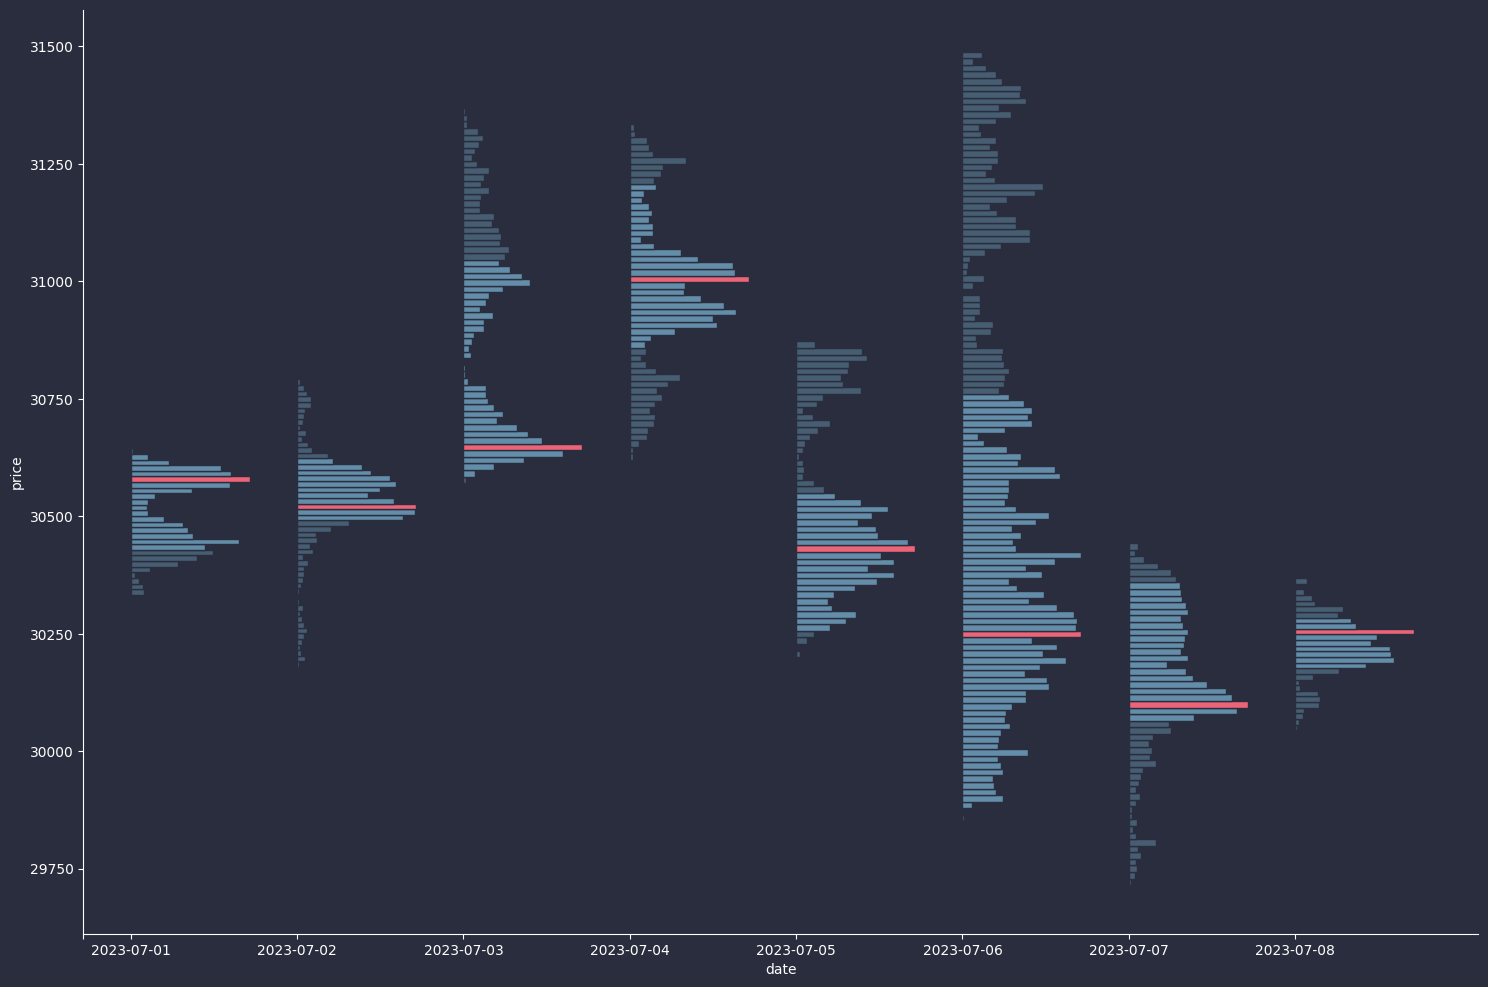

In [4]:
fig,ax = plt.subplots(figsize=(18,12))
# vol value is used to create an offset between the charts
# change the vol value to change the offset from the left corner of the chart
vol_value = 200
# vol value list starts with 0 to create an offset from the left of the chart. 
vol_value_list = [0,vol_value]
date_list = ['']
for date in date_range(datetime.date(2023, 7, 1), datetime.date(2023, 7, 9)):
    df = pd.read_csv(ZipFile("../data/spot/daily/aggTrades/BTCUSDT/BTCUSDT-aggTrades-" + date + ".zip").open("BTCUSDT-aggTrades-" + date + ".csv"), names=["aggregated_id","price","quantity","first_trade_id","last_trade_id","last_timestamp","is_buyer_maker","is_best_match"])

    # Create volume profile
    bins, volume_profile = create_volume_profile_ticks_standard(df.copy())

    # Calculate the Value Area (using the function with dual bins)
    percentage = 68
    value_area_low, value_area_high = calculate_value_area_with_highest_dual_bins(bins, volume_profile, percentage)
    colors = ['#EC6477' if bins[i] == calculate_point_of_control(bins, volume_profile) else ('#638DA8' if value_area_low <= bins[i] <= value_area_high else '#638DA880') for i in range(len(bins))]
    
    if vol_value != 0:
        ax.barh(bins, volume_profile, height=(bins[1]-bins[0]), align='edge', ec='#2A2D3D', color=colors, left = vol_value)
    else:   
        ax.barh(bins, volume_profile, height=(bins[1]-bins[0]), align='edge', ec='#2A2D3D', color=colors)
    
    vol_value += max(volume_profile) + 200
    # list for plotting the date on the x axis
    vol_value_list.append(vol_value)
    date_list.append(date)

#interior plot color
ax.set_facecolor('#2A2D3D')
#exterior plot color
fig.set_facecolor('#2A2D3D')
ax.spines['bottom'].set_color('#FFFFFF')
ax.spines['top'].set_color('#FFFFFF00')
ax.spines['left'].set_color('#FFFFFF')
ax.spines['right'].set_color('#FFFFFF00')
ax.xaxis.label.set_color('#FFFFFF')
ax.yaxis.label.set_color('#FFFFFF')
ax.tick_params(axis='x', colors='#FFFFFF')
ax.tick_params(axis='y', colors='#FFFFFF')
ax.set_xticks(vol_value_list[:-1])
ax.set_xticklabels(date_list)
plt.xlabel('date')
plt.ylabel('price')
plt.show()